In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

# Read in and process data

Define what csv files to use

In [2]:
# # cellpose_file = "cellpose_results/cellpose_run04_240427113411.csv"
# # cellpose_file = "cellpose_results/cellpose_run04_240501153104.csv"
# cellpose_file = "cellpose_results/cellpose_run05_240527232502.csv"
cellpose_file = "cellpose_results/cellpose_run06_240601015117.csv"
# # food_file = "FoodSeg103_results/food_run04_240428133857.csv"
# # food_file = "FoodSeg103_results/food_run04_240501155333.csv"
# food_file = "FoodSeg103_results/food_run05_240531110123.csv"
food_file = "FoodSeg103_results/food_run06_240531234417.csv"

Load raw dataframes and process them

In [107]:
# Load the dataframes from the csv files
# cellpose_df = pd.read_csv(cellpose_file)
# food_df = pd.read_csv(food_file)

# For each metric, add additional infos/columns
# for df in [cellpose_df, food_df]:
#     for metric in ['accuracy', 'mIoU', 'mPrecision', 'mRecall', 'mF1']:
#         for scr in df['scribbles'].unique():
            
            # # Add a column for the improvement over the ilastik prediction
            # perf_il = df.loc[(df['scribbles'] == scr) & (df['prediction tag'] == "ilastik"), metric].values[0]
            # df.loc[(df['scribbles'] == scr), f'{metric}_impr_to_ilastik'] = df.loc[(df['scribbles'] == scr), metric] - perf_il

    #         # Add a column stating which model of each prediciton type is best (especially interesting for convpaint)
    #         scr_df = df.loc[df['scribbles'] == scr]
    #         for pred_type in scr_df['prediction type'].unique():
    #             pred_type_df = scr_df[scr_df['prediction type'] == pred_type]
    #             best_idx = pred_type_df[metric].idxmax()
    #             df.loc[best_idx, f"best_{metric}"] = df.loc[best_idx, "prediction tag"]
    # # Replace NA by blanks
    # df.fillna("", inplace=True)

# # Show the dataframes
# for df in [cellpose_df, food_df]:
#     # Show shape, the first rows and the mean values for each scribbles bin
#     print(df.shape)
#     print(df.columns)
#     # display(df[:15])
#     # display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

Save processed dataframes to csv files

In [108]:
# cellpose_df.to_csv(f'{cellpose_file[:-4]}_processed.csv', index=False)
# food_df.to_csv(f'{food_file[:-4]}_processed.csv', index=False)

Load already processed dataframes from the csv files

In [3]:
cellpose_df = pd.read_csv(f'{cellpose_file[:-4]}_processed.csv')
food_df = pd.read_csv(f'{food_file[:-4]}_processed.csv')
# cellpose_df.fillna("-", inplace=True)
# food_df.fillna("-", inplace=True)

for df in [cellpose_df, food_df]:
    # Show shape, the first rows and the mean values for each scribbles bin
    print(df.shape)
    # display(df[:15])
    display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

(75600, 38)


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.010,0.007990,14.737037,0.745525
0.025,0.020697,38.285185,0.780011
0.050,0.043617,80.861111,0.827771
0.100,0.091388,169.290741,0.850123
0.250,0.238859,440.588889,0.873399
0.500,0.485618,894.625926,0.885517
1.000,0.979729,1802.866667,0.894358
2.500,2.449240,4505.262963,0.904233
5.000,4.841458,8897.888889,0.911786


(72800, 32)


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.010,0.008690,15.500000,0.533903
0.025,0.022307,39.584615,0.550114
0.050,0.044698,78.934615,0.568328
0.100,0.090498,160.761538,0.602415
0.250,0.227867,403.101923,0.664357
0.500,0.449823,793.932692,0.716323
1.000,0.898720,1592.111538,0.777659
2.500,2.306416,4090.367308,0.847959
5.000,4.633788,8187.111538,0.886143


# Choose performance METRIC and DATASET

In [43]:
metric = "accuracy"
# metric = "mPrecision"
# metric = "mRecall"
# metric = "mIoU"
# metric = "mF1"

In [44]:
use_for_all = "cellpose"
# use_for_all = "food"

# Inspect the dataset

### Check for extreme cases by sorting

Examples: best cases for certain model, or worst performance compared to Ilastik

In [204]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[df_filtered['layers'] == 0]
# df_filtered = df_filtered[df_filtered['scalings'] == 1]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# List the 10 cases where convpaint performs the worst compared to ilastik
df_filtered.sort_values(by=f'{metric}_impr_to_ilastik', ascending=True)[0:10][['img_num', 'accuracy', 'accuracy_impr_to_ilastik', 'scribbles bin', 'perc. labelled', 'pix_in_img', 'min_class_pix_gt']]

,img_num,accuracy,accuracy_impr_to_ilastik,scribbles bin,perc. labelled,pix_in_img,min_class_pix_gt
13161,94,0.308756,-0.503250,0.010,0.007500,160000,77693
14001,100,0.358479,-0.477472,0.010,0.008889,202500,81266
28015,200,0.441341,-0.427631,0.025,0.021362,262144,37187
45935,328,0.273126,-0.386980,0.025,0.018406,195584,56212
53915,385,0.626669,-0.341016,0.025,0.021943,414720,15976
3921,28,0.622297,-0.307666,0.010,0.008669,196096,36220
57541,411,0.521810,-0.287558,0.010,0.007038,113664,23228
30535,218,0.493612,-0.272578,0.025,0.021871,196608,57352
15289,109,0.473541,-0.272415,0.050,0.042725,196608,47509
51115,365,0.569454,-0.268175,0.025,0.023759,50508,23805


### Check distribution of performance among the dataset

In [205]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

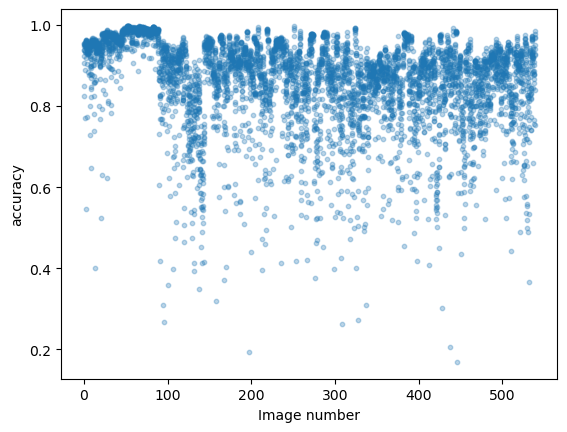

In [206]:
# Plot
plt.scatter(df_filtered['img_num'], df_filtered[metric], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel(metric)
plt.show()

# Check distribution of the _improvements over Ilastik_ among the dataset

In [207]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

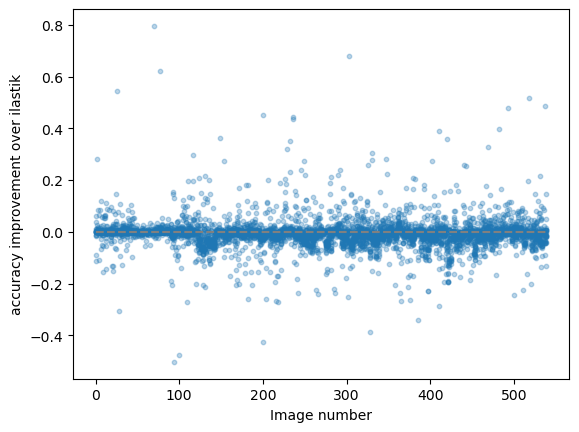

In [208]:
# Plot
plt.scatter(x = df_filtered['img_num'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel(f'{metric} improvement over ilastik')
plt.hlines(0, np.min(df_filtered['img_num']), np.max(df_filtered['img_num']), colors='grey', linestyles='dashed')
plt.show()

### Correlation between pixels labelled and improvement

Cellpose: Pixels labelled in one or the other class (not working for FoodSeg103 with multiple classes)

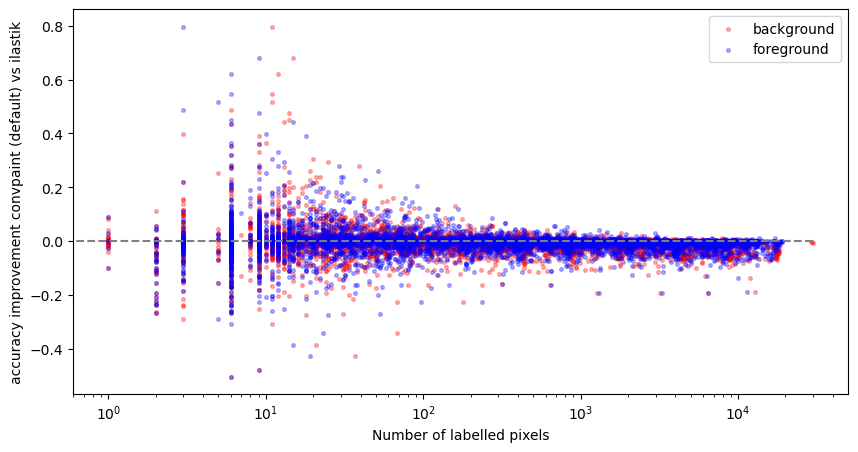

In [209]:
if use_for_all == "cellpose":
    # Define which dataframe to use
    df = cellpose_df.copy()

    # Optionally filter the dataframe
    df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
    # df_filtered = df_filtered[(df['scribbles bin'] == 1)]

    # Plot
    plt.figure(figsize=(10, 5), dpi=100)
    plt.scatter(df_filtered["class_1_pix_labelled"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=7, c="red", label="background")
    plt.scatter(df_filtered["class_2_pix_labelled"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=7, c = "blue", label="foreground")
    plt.xlabel("Number of labelled pixels")
    plt.xscale("log")
    plt.hlines(0, 0, np.max([np.max(df_filtered["class_1_pix_labelled"]), np.max(df_filtered["class_1_pix_labelled"])]), colors='grey', linestyles='dashed')
    plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
    plt.legend()
    plt.show()
else:
    print("Plot only available for cellpose data")

Minimum/maximum pixels labelled among classes

In [210]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

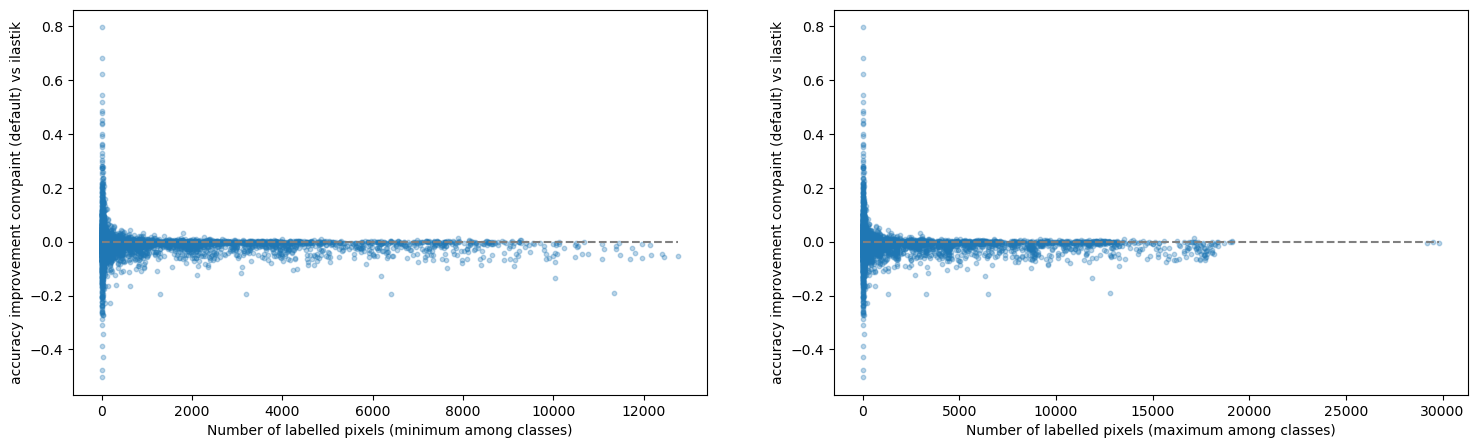

In [211]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
ax1.scatter(x = df_filtered['min_class_pix_labelled'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
ax1.set_xlabel("Number of labelled pixels (minimum among classes)")
# ax1.set_xscale("log")
ax1.hlines(0, np.min(df_filtered['min_class_pix_labelled']), np.max(df_filtered['min_class_pix_labelled']), colors='grey', linestyles='dashed')
ax1.set_ylabel(f'{metric} improvement convpaint (default) vs ilastik')
ax2.scatter(x = df_filtered['max_class_pix_labelled'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
ax2.set_xlabel("Number of labelled pixels (maximum among classes)")
# ax2.set_xscale("log")
ax2.hlines(0, np.min(df_filtered['max_class_pix_labelled']), np.max(df_filtered['max_class_pix_labelled']), colors='grey', linestyles='dashed')
ax2.set_ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.show()

### Correlation between the resolution (# pixels) and the improvement

In [212]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

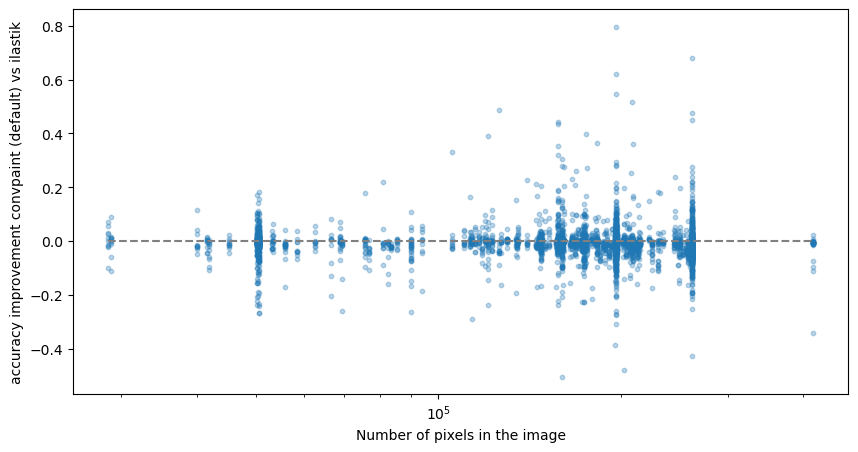

In [213]:
# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_filtered["pix_in_img"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
plt.xlabel("Number of pixels in the image")
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.hlines(0, np.min(df_filtered["pix_in_img"]), np.max(df_filtered["pix_in_img"]), colors='grey', linestyles='dashed')
plt.xscale("log")
plt.show()

# Compare bins

### Improvement over Ilastik

In [214]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

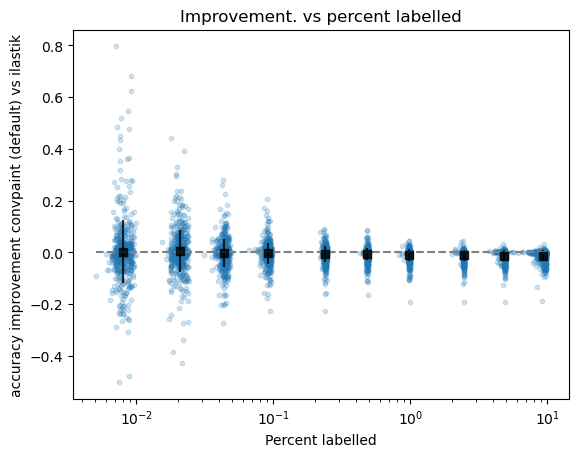

In [215]:
# Plot
plt.scatter(df_filtered['perc. labelled'], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.2, s=10)
df_grouped = df_filtered.groupby('scribbles bin').agg({f'{metric}_impr_to_ilastik': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[f'{metric}_impr_to_ilastik']['mean'], yerr=df_grouped[f'{metric}_impr_to_ilastik']['std'], fmt='s', c='black', alpha=0.8)
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.hlines(0, np.min(df_filtered['perc. labelled']), np.max(df_filtered['perc. labelled']), colors='grey', linestyles='dashed')
plt.title('Improvement. vs percent labelled')
plt.show()

### Performance of different models on separate dotplots side-by-side

In [216]:
def plot_perf_vs_perc_labelled(df, pred_to_show="convpaint", plt_ax=None, **kwargs):
    if plt_ax is None:
        plt_ax = plt.subplots(1, 1)[1]
    
    if pred_to_show:
        df_exact = df[df['prediction tag'] == pred_to_show]
        if len(df_exact) == 0:
            df_filtered = df[df['prediction tag'].str.contains(pred_to_show)]
        else:
            df_filtered = df_exact

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered[metric], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({metric: ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel(metric)
    plt_ax.set_title(f'{metric} vs percent labelled {pred_to_show}')

In [217]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Which convpaint model to use and compare to ilastik and dino
convpaint_model = 'convpaint_l-0_s-1-2'

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df[df[f'best_{metric}'].str.contains('convpaint')]
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

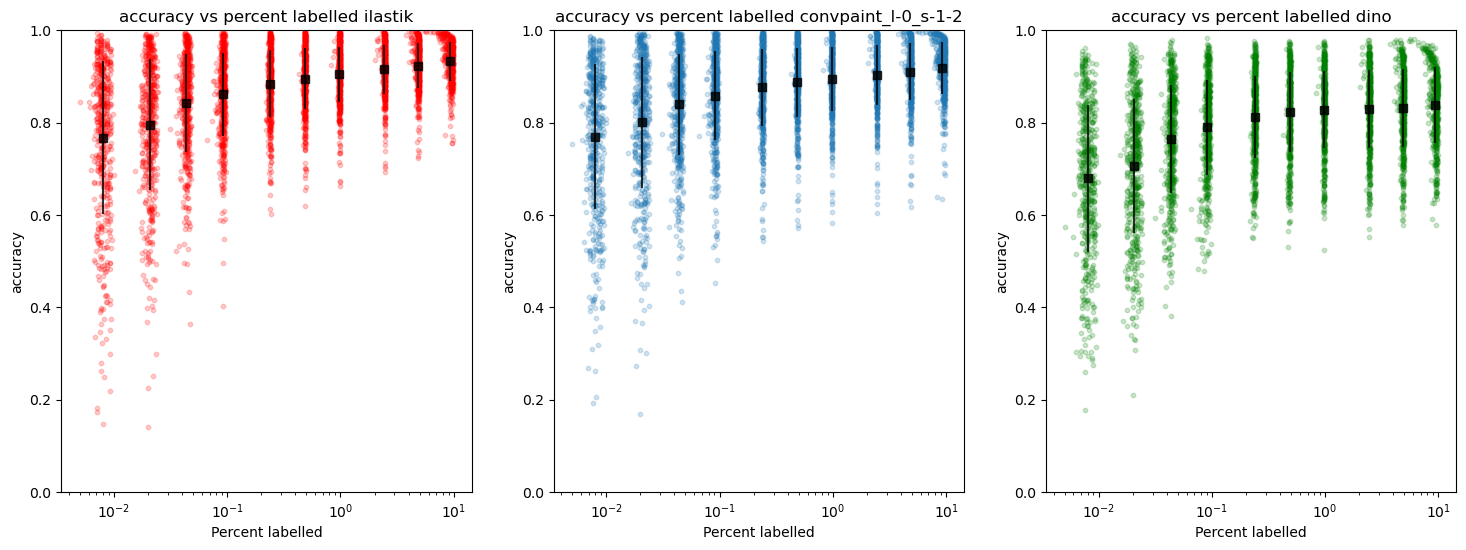

In [218]:
# Filter the predictions to show
pred_tag_1 = 'ilastik'
pred_tag_2 = convpaint_model
pred_tag_3 = 'dino'

# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.set_dpi(100)
plot_perf_vs_perc_labelled(df, pred_tag_1, plt_ax=ax[0], c='red')
plot_perf_vs_perc_labelled(df, pred_tag_2, plt_ax=ax[1])
plot_perf_vs_perc_labelled(df, pred_tag_3, plt_ax=ax[2], c='green')

# plt.savefig(f'{cellpose_file[:-4]}_{metric}-vs-labels.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_{metric}-vs-labels.pdf', dpi=300)
plt.show()

### Performance of different models on same dotplot

In [219]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Which convpaint model to use and compare to ilastik and dino
convpaint_model = 'convpaint_l-0_s-1-2'
# If we want to use the best model for each prediction type, we only filter the tag for "convpaint"
# convpaint_model = 'convpaint'
# df = df[df[f'best_{metric}'].str.len() > 1]

# Optionally filter the dataframe
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

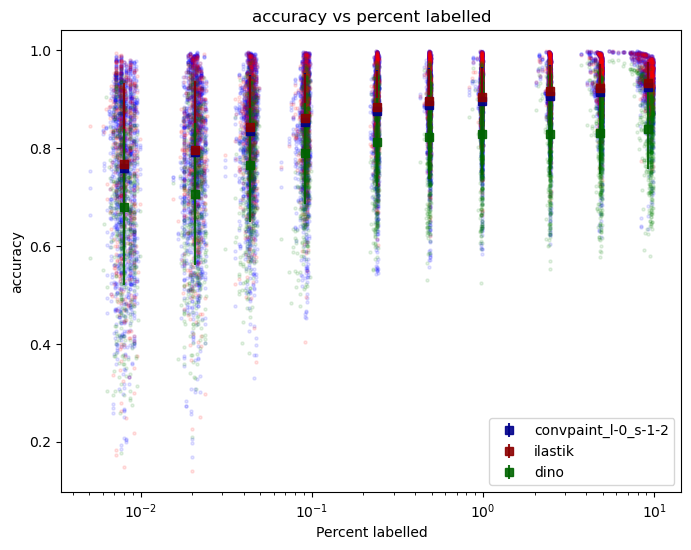

In [220]:
# Define the predictions to show and created filtered dataframes
pred_tag_1 = convpaint_model
pred_tag_2 = 'ilastik'
pred_tag_3 = 'dino'
df_filtered_1 = df[df['prediction tag'].str.contains(pred_tag_1)]
df_filtered_2 = df[df['prediction tag'].str.contains(pred_tag_2)]
df_filtered_3 = df[df['prediction tag'].str.contains(pred_tag_3)]

# Plot performance vs percent labelled
plt.figure(figsize=(8,6),dpi=100)

# ADD FIRST PLOT
# Scatterplot
plt.scatter(df_filtered_1['perc. labelled'], df_filtered_1[metric], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_filtered_1.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkblue', alpha=0.9, label=pred_tag_1)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD SECOND PLOT
# Scatterplot
plt.scatter(df_filtered_2['perc. labelled'], df_filtered_2[metric], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_filtered_2.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkred', alpha=0.9, label=pred_tag_2)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADD THIRD PLOT
# Scatterplot
plt.scatter(df_filtered_3['perc. labelled'], df_filtered_3[metric], alpha=0.1, s=5, c='green')
# Grouped plot
df_grouped = df_filtered_3.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkgreen', alpha=0.9, label=pred_tag_3)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel(metric)
plt.title(f'{metric} vs percent labelled')
plt.legend()
plt.show()

### VIOLINPLOT (performance vs. percent labelled)

In [221]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Which models to compare
pred_tag_1 = 'convpaint_l-0_s-1-2'
pred_tag_2 = 'ilastik'
# If we want to use the best model for each prediction type, we only filter the tag for "convpaint"
# pred_tag_1 = 'convpaint'
# df = df[df[f'best_{metric}'].str.len() > 1]

# Optionally filter the dataframe
# df = df[(df['scribbles bin'] > 1)] #& (df['scribbles bin'] < 10)]
# bins_to_use = [0.01, 0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

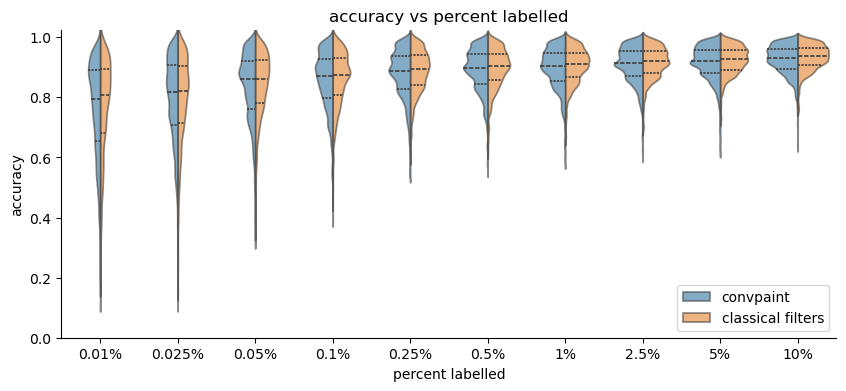

In [222]:
# Filter for the predicitons to use
df_filtered_1 = df[df['prediction tag'].str.contains(pred_tag_1)]
df_filtered_2 = df[df['prediction tag'].str.contains(pred_tag_2)]
df_both = pd.concat([df_filtered_1, df_filtered_2])

# Plot performance vs percent labelled (violin plot)
plt.figure(figsize=(10, 4), dpi=100)

# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y=metric, data=df_both, hue='prediction type', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_filtered_1_grouped = df_filtered_1.groupby('scribbles bin').agg({metric: 'median'}).reset_index()
df_filtered_2_grouped = df_filtered_2.groupby('scribbles bin').agg({metric: 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
# plt.plot(x_positions, df_filtered_1_grouped[metric], color='lightblue', alpha=0.8)
# plt.plot(x_positions, df_filtered_2_grouped[metric], color='orange', alpha=0.7)
# original colours: lightblue, orange

# Set some parameters
x_labels = [f"{int(x) if int(x)==x else x}%" for x in df_filtered_1_grouped['scribbles bin']]

plt.ylim(0, 1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.legend(loc='lower right')
plt.xlabel('percent labelled')
plt.ylabel(metric)
plt.title(f'{metric} vs percent labelled')

# Show or save the plot
# plt.savefig(f'{cellpose_file[:-4]}_{metric}-vs-labels_convpaint-vs-ilastik.pdf", format='pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_{metric}-vs-labels_convpaint-vs-ilastik.pdf", format='pdf', dpi=300)
plt.show()

# Compare VGG16 layer/scaling combos

In [223]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter before comparing prediciton types (not for models, but e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

In [224]:
# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# Create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction tag'].str.contains('convpaint')] for single_bin_df in bin_df_list]

In [225]:
# Check if the list is composed as intended
# bin_df_list_conv[-1][bin_df_list_conv[-1]['img_num'] == 0]

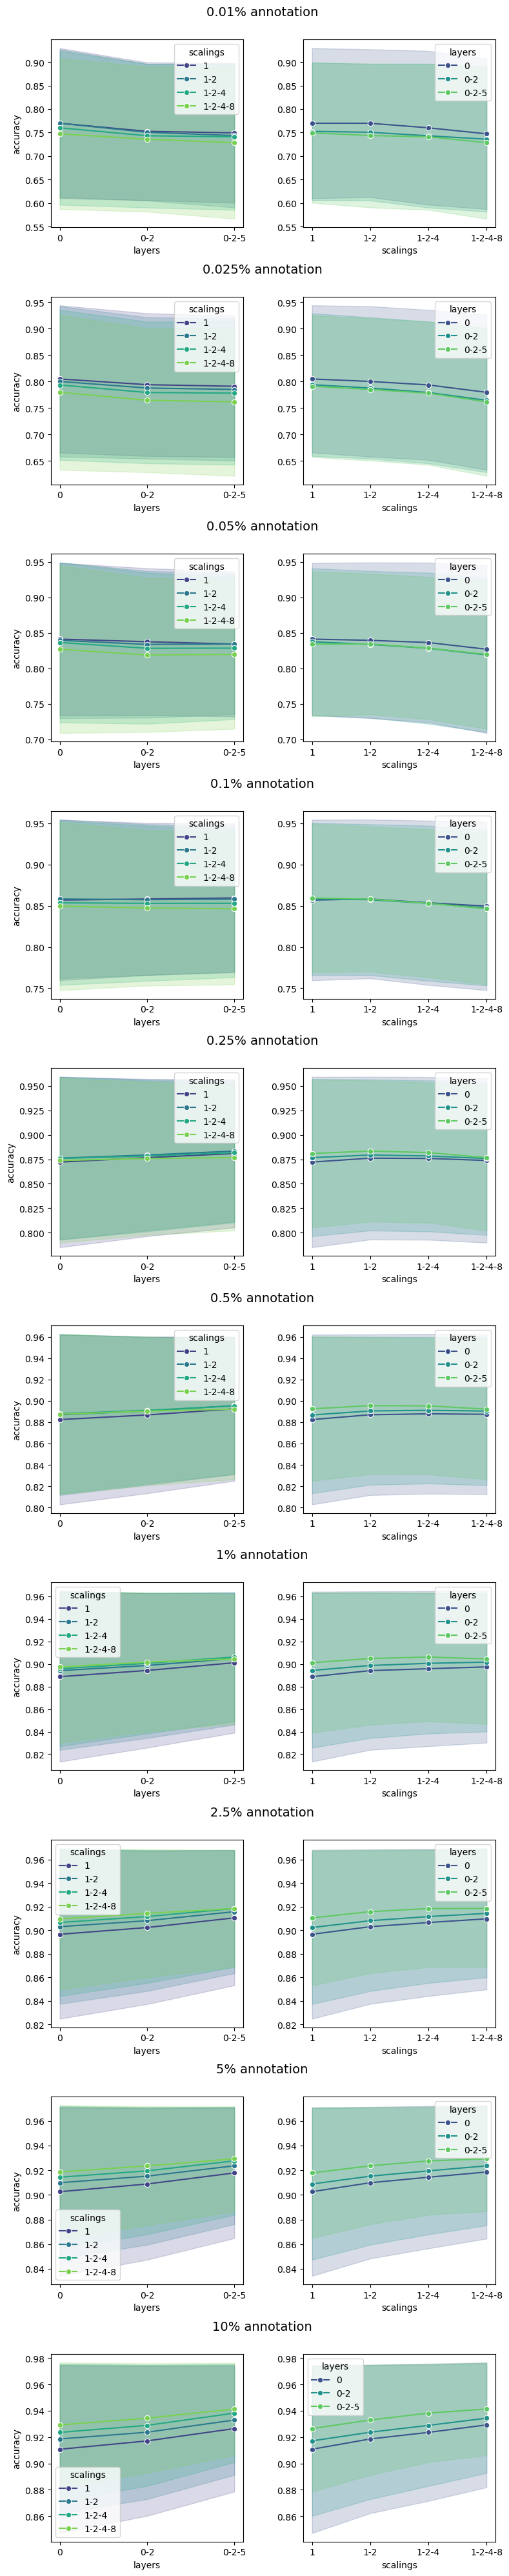

In [226]:
# Plot
num_df = len(bin_df_list_conv)
fig, ax = plt.subplots(num_df, 2)
# ax = np.array([ax]) # If we have only 1 df, we need to convert the ax to a 2D array

fig.set_size_inches(8, 4 * num_df)
fig.set_dpi(100)

for i, df in enumerate(bin_df_list_conv):
    row = ax[i]
    sns.lineplot(x='layers', y=metric, data=df, hue='scalings', palette='viridis', errorbar='sd', marker='o',ax=row[0])
    sns.lineplot(x='scalings', y=metric, data=df, hue='layers', palette='viridis', errorbar='sd', marker='o',ax=row[1])
    # Hide y axis label of right plot
    row[0].set_title(f"{annot_bins[i]}% annotation", x=1.1, y=1.1, fontsize=14)
    row[1].set_ylabel('')
    # if i != num_df-1:
    #     row[0].set_xlabel('')
    #     row[1].set_xlabel('')
fig.tight_layout()
plt.show()

### Correlation between image resolution and effect of VGG16 scalings

In [227]:
scalings_to_comp = ['1-2-4-8', '1']

In [228]:
grouped_dfs = []
for df_conv_bin in bin_df_list_conv:
    # df_conv_bin = df_conv_bin[df_conv_bin['layers']=='0']
    # Group by 'img_num' and 'scalings' to compute average performance metric
    grouped_df = df_conv_bin.groupby(['img_num', 'scalings'])[metric].mean().unstack()
    grouped_df['img_num'] = grouped_df.index
    grouped_df['pix_in_img'] = df_conv_bin.groupby('img_num')['pix_in_img'].first().values
    grouped_df[f'{metric}_diff'] = grouped_df[scalings_to_comp[0]] - grouped_df[scalings_to_comp[1]]
    grouped_dfs.append(grouped_df)
# Display the result
grouped_dfs[0][:4]

scalings,1,1-2,1-2-4,1-2-4-8,img_num,pix_in_img,accuracy_diff
img_num,,,,,,,
0,0.824962,0.793676,0.763403,0.757396,0,196096,-0.067566
1,0.827979,0.802121,0.807533,0.806326,1,196096,-0.021653
2,0.677629,0.661351,0.510614,0.484028,2,196096,-0.193601
3,0.829852,0.818798,0.841054,0.828633,3,196096,-0.001219


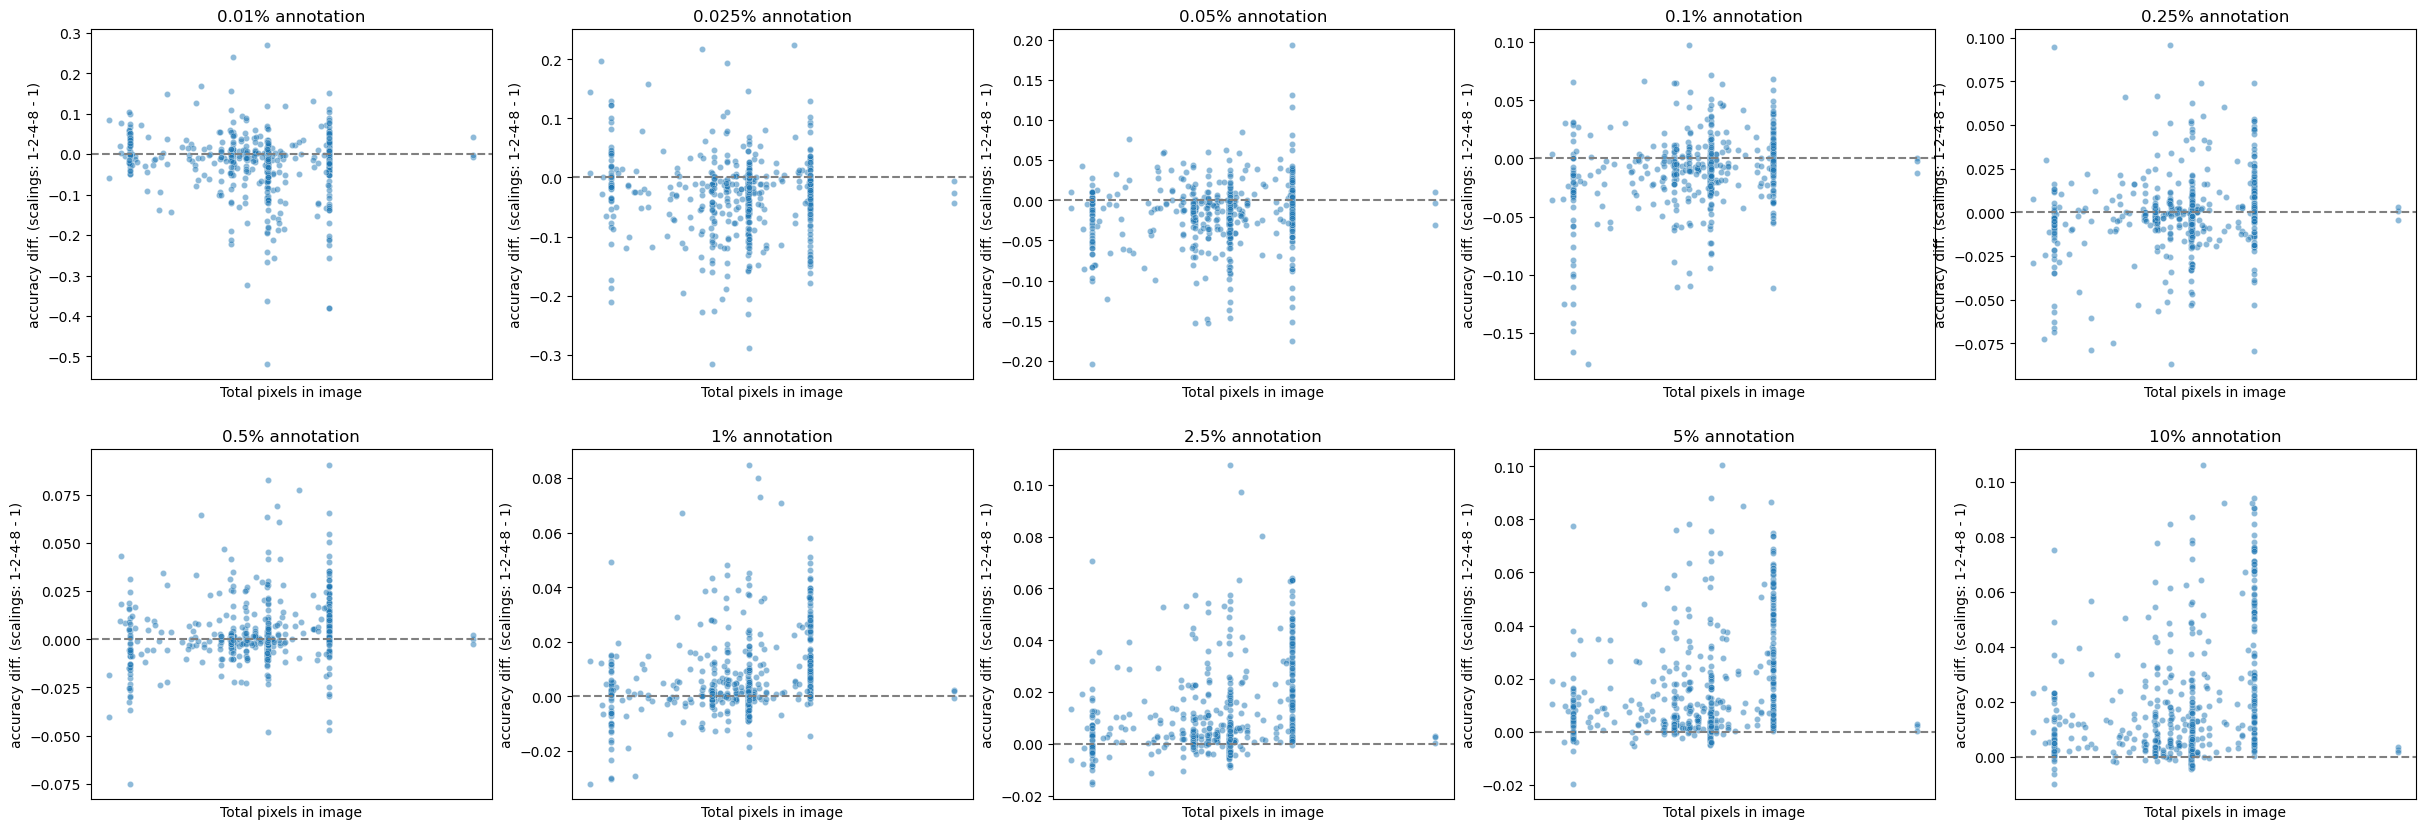

In [229]:
num_cols = int(np.ceil(num_df/2)) if num_df > 3 else num_df
num_rows = 2 if num_df > 3 else 1
fig, ax = plt.subplots(num_rows, num_cols)
ax = np.array([ax]) # If we have only 1 df, we need to convert the ax to a 2D array
ax = ax.flatten()
fig.set_size_inches(6*num_cols, 5*num_rows)
fig.set_dpi(100)
for i, grouped_df in enumerate(grouped_dfs):
    curr_ax = ax[i]
    sns.scatterplot(x='pix_in_img', y=f'{metric}_diff', data=grouped_df, s=20, alpha=0.5, ax=curr_ax)
    # curr_ax.set_xscale('log')
    # curr_ax.set_yscale('log')
    curr_ax.axhline(0, color='grey', linestyle='--')
    curr_ax.set_xticks([])    
    curr_ax.set_xlabel('Total pixels in image')
    curr_ax.set_ylabel(f'{metric} diff. (scalings: {scalings_to_comp[0]} - {scalings_to_comp[1]})')
    curr_ax.set_title(f'{annot_bins[i]}% annotation')
plt.show()

# HEATMAPS for model comparison

### Different ConvPaint models (layers/scaling combinations)

In [230]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter before comparing prediciton types (e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
bins_to_use = [0.1, 1, 10]
df = df[df['scribbles bin'].isin(bins_to_use)]

In [231]:
# Take only convpaint predictions
df = df[df['prediction tag'].str.contains('convpaint')]

# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]
bin_df_list_conv = bin_df_list

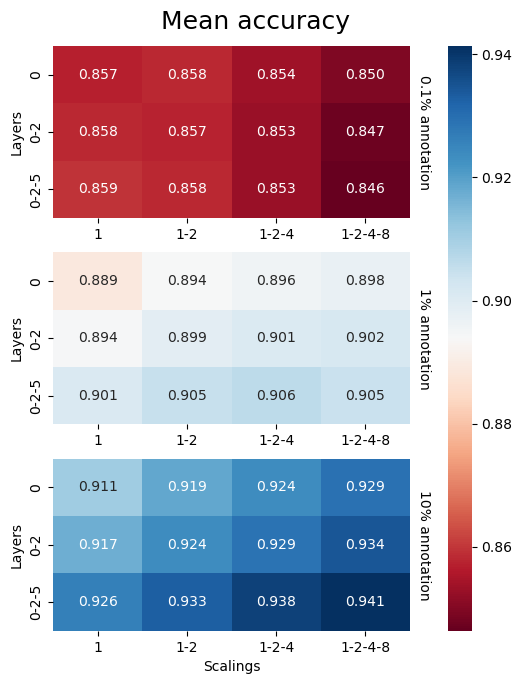

In [232]:
num_bins = len(annot_bins)
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])
axis_matrix = [[str(bin), 'cbar'] for bin in annot_bins]
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [15, 1]})
ax_list = [ax[str(bin)] for bin in annot_bins]

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 12 * num_bins) * ratio # title + bottom + plot per bin
plot_width = 18 * (30) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'Mean {metric}', fontsize=18, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

for i, df in enumerate(bin_df_list_conv):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values=metric)
    sns.heatmap(heatmap_df_mean, annot=True, cmap="RdBu", fmt=".3f", cbar=i==0, cbar_ax=ax['cbar'], ax=row, vmin=min_val, vmax=max_val)
    row.text(1.02, 0.5, f'{annot_bins[i]}% annotation', transform=row.transAxes, rotation=270, va='center')
    row.set_xlabel('Scalings' if i == num_bins - 1 else '')
    row.set_ylabel('Layers')

    # row.set_aspect('auto')

# plt.savefig(f'{cellpose_file[:-4]}_avg_{metric}_heatmap_convpaint.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_avg_{metric}_heatmap_convpaint.pdf', dpi=300)
plt.show()

### Convpaint models vs. Ilastik and DINOv2

In [233]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
# bins_to_use = [0.025, 0.5, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

In [234]:
# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# For each model, create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction tag'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ilastik = [single_bin_df[single_bin_df['prediction tag'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction tag'].str.contains('dino')] for single_bin_df in bin_df_list]

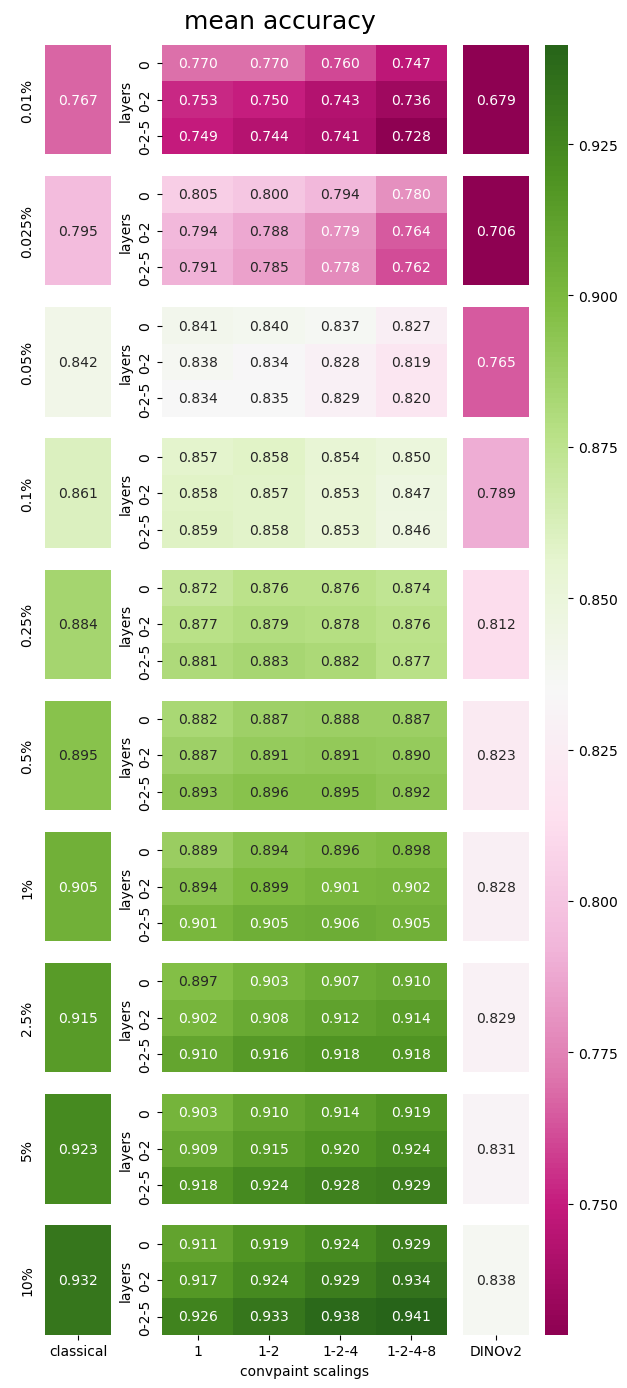

In [235]:
plot_metric = metric
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])
# plot_metric = f"{metric}_impr_to_ilastik"
# min_val = -0.05#min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
# max_val = 0.05 #max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])

num_bins = len(annot_bins)
axis_matrix = np.array([['pad left', 
                          str(bin)+'ilastik', 
                          'pad', 
                          str(bin)+'convpaint', 
                          str(bin)+'dino', 
                          'cbar'] for bin in annot_bins])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [1, 3.5, 1, 15, 3.5, 1.2]})
for pad in ['pad left', 'pad']: ax[pad].axis('off')

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 8 * num_bins) * ratio # title + bottom + plot per bin
plot_width = unit * (40) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean {plot_metric}', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

heatmap_cfg = {"annot":True, "cmap":"PiYG", "fmt":".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}
# original cmap = 'YlGnBu'; good alternatives: twilight_shifted, RdBu, PuBuGn, PuBu, BuGn, PiYG

# CONVPAINT
ax_list_conv = [ax[ax_idx] for ax_idx in axis_matrix[:,3]]#[ax['upper left'], ax['mid left'], ax['lower left']]
for i, df in enumerate(bin_df_list_conv):
    row = ax_list_conv[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values=plot_metric)
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('convpaint scalings' if i == num_bins - 1 else '')
    if not i == num_bins - 1: row.set_xticks([])
    row.set_ylabel('layers')

# ILASTIK
ax_list_ila = [ax[ax_idx] for ax_idx in axis_matrix[:,1]] #[ax['upper mid'], ax['mid mid'], ax['lower mid']]
for i, df in enumerate(bin_df_list_ilastik):
    row = ax_list_ila[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df[plot_metric].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["classical"])
    else:
        row.set_xticks([])
    row.set_yticks([])
    row.text(-0.37, 0.5, f'{annot_bins[i]}%', transform=row.transAxes, rotation=90, va='center')

# DINOv2
ax_list_dino = [ax[ax_idx] for ax_idx in axis_matrix[:,4]]
for i, df in enumerate(bin_df_list_dino):
    row = ax_list_dino[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df[plot_metric].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["DINOv2"])
    else:
        row.set_xticks([])
    row.set_yticks([])

# plt.savefig(f'{cellpose_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
plt.show()

## Create heatmap with BEST models

In [236]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Take only the best predictions
df = df[df[f'best_{metric}'].str.len() > 1]

# Optionally filter the dataframe
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
bins_to_use = [0.025,0.1, 0.5, 2.5, 10]
df = df[df['scribbles bin'].isin(bins_to_use)]

In [237]:
# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

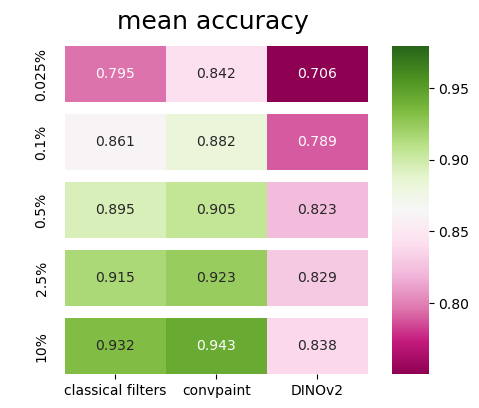

In [238]:
num_bins = len(annot_bins)
plot_metric = metric
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list])

axis_matrix = np.array([['pad left', 
                          str(bin)+'heatmap', 
                          'cbar'] for bin in annot_bins])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [1, 10, 1.2]})
ax_list = [ax[ax_idx] for ax_idx in axis_matrix[:,1]]
ax['pad left'].axis('off')

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 4 * num_bins) * ratio # title + bottom + plot per bin
plot_width = unit * (30) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean {plot_metric}', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))

heatmap_cfg = {"annot":True, "cmap":"PiYG", "fmt":".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}

for i, df in enumerate(bin_df_list):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(columns='prediction type', values=plot_metric)[['classical filters', 'convpaint', 'DINOv2']]
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('')
    if not i == num_bins - 1: row.set_xticks([])
    row.set_yticks([])
    row.text(-0.1, 0.5, f'{annot_bins[i]}%', transform=row.transAxes, rotation=90, va='center')

# Plot Computation Times

Load dataframes from csv files (different to the performance measures)

In [23]:
cellpose_time_file = "cellpose_results/cellpose_time_prelim1.csv"
food_time_file = "FoodSeg103_results/food_time_prelim1.csv"

In [27]:
cellpose_time_df = pd.read_csv(cellpose_time_file)
food_time_df = pd.read_csv(food_time_file)

Choose which data to plot and filter for convpaint, ilastik and dino to split the data

In [34]:
time_df = cellpose_time_df.copy()
# time_df = food_time_df.copy()
# time_df = {"cellpose": cellpose_time_df.copy(), "food": food_time_df.copy()}[use_for_all]

In [35]:
time_df_conv = time_df[time_df['prediction type'] == 'convpaint']
time_df_ilastik = time_df[time_df['prediction type'] == 'classical filters']
time_df_dino = time_df[time_df['prediction type'] == 'DINOv2']

In [47]:
time_df.groupby(['prediction type','layers', 'scalings']).agg({"t_features": "mean", "t_pred": "mean", "t_tot": "mean"}).round(2)

t_features  t_pred  t_tot
prediction type   layers scalings                           
DINOv2            -      -               2.20    0.48   2.67
classical filters -      -               0.38    0.81   1.20
convpaint         0      1               0.04    1.22   1.38
                         1-2             0.06    1.35   1.69
                         1-2-4           0.10    1.32   1.81
                         1-2-4-8         0.11    1.27   1.85
                  0-2    1               0.22    1.22   1.63
                         1-2             0.33    1.61   2.48
                         1-2-4           0.42    2.06   3.34
                         1-2-4-8         0.44    2.36   4.04
                  0-2-5  1               0.48    1.82   2.92
                         1-2             0.64    2.32   4.06
                         1-2-4           0.72    2.89   5.48
                         1-2-4-8         0.86    4.50   7.38

Plot the heatmaps

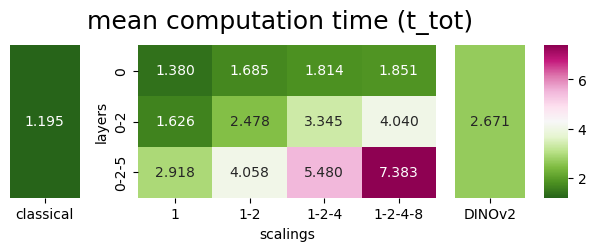

In [51]:
time_to_use = "t_tot"
heatmap_df_mean_conv = time_df_conv.pivot_table(index='layers', columns='scalings', values=time_to_use)
heatmap_df_mean_ila = time_df_ilastik[time_to_use].mean().reshape((1,1))
heatmap_df_mean_dino = time_df_dino[time_to_use].mean().reshape((1,1))

axis_matrix = np.array([['ilastik', 
                         'pad',
                         'convpaint', 
                         'dino', 
                         'cbar']])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [3.5, 1, 15, 3.5, 1.2]})

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + 10 * ratio # title + bottom + plot per bin
plot_width = unit * (40) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean computation time ({time_to_use})', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))

# fig.set_size_inches(8, 4)
# fig.set_dpi(100)

min_val = min([heatmap_df_mean_conv.min().min(), heatmap_df_mean_ila, heatmap_df_mean_dino])
max_val = max([heatmap_df_mean_conv.max().max(), heatmap_df_mean_ila, heatmap_df_mean_dino])
# If we want to have classical filters centered:
# max_dist_to_classical = max(abs(heatmap_df_mean_ila - min_val), abs(max_val - heatmap_df_mean_ila))
# min_val = heatmap_df_mean_ila - max_dist_to_classical
# max_val = heatmap_df_mean_ila + max_dist_to_classical
heatmap_cfg = {"annot":True, "cmap":"PiYG_r", "fmt":".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}
# original cmap = 'YlGnBu'; good alternatives: twilight_shifted, RdBu, PuBuGn, PuBu, BuGn, PiYG

# PLOT
sns.heatmap(heatmap_df_mean_conv, cbar=True, ax=ax['convpaint'], **heatmap_cfg)
sns.heatmap(heatmap_df_mean_ila, cbar=True, ax=ax['ilastik'], **heatmap_cfg)
sns.heatmap(heatmap_df_mean_dino, cbar=True, ax=ax['dino'], **heatmap_cfg)

ax["ilastik"].set_xticklabels(["classical"])
ax["ilastik"].set_yticks([])
ax["dino"].set_xticklabels(["DINOv2"])
ax["dino"].set_yticks([])
ax['pad'].axis('off')

# plt.savefig(f'{cellpose_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
# plt.savefig(f'{food_file[:-4]}_avg_{metric}_heatmap.pdf', dpi=300)
plt.show()